In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import threading

In [27]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Actor Critic Implementation

In [28]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.policy = nn.Linear(hidden_dim, output_dim)
        self.value = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        policy_logits = self.policy(x)
        value = self.value(x)
        return policy_logits, value

In [19]:
def compute_returns(rewards, gamma=0.99):
    R = 0
    rtns = []
    for r in reversed(rewards):
        R = r + gamma * R
        rtns.insert(0, R)   #here we are prepending with 0 so tha the returns can align with original order later
    return rtns

In [24]:
def worker_thread(IDthread, global_model, optimizer, epLock, optimLock, glob_epref, glob_epRwd, maxEp, env_name):
    env = gym.make(env_name)                                                      #The idea here is that each thread creates its own local environment and syncs with the global model from time to time
    env.reset(seed=seed + IDthread)          #To differenciate we are setting unique seeds with thread ID, to easily identify
    local_model = ActorCritic(input_dim=env.observation_space.shape[0],hidden_dim=256,output_dim=env.action_space.n)
    local_model.load_state_dict(global_model.state_dict())          #We are creating a copy of global model
    local_model.to(device)
    gamma = 0.99
    entropy_coeff = 0.01                                       # we know that entropy pushes the model to explore
    print(f"The thread with thread ID {IDthread} is now stated to train.")
    
    while True:
        with epLock:                       #hre we are incrementing the global episode 
            if glob_epref[0] >= maxEp:
                break
            epID = glob_epref[0]
            glob_epref[0] += 1

        state, _ = env.reset()  
        log_probs = []                 #now we start to run one episode
        entropies = []
        values = []
        rewards = []
        done = False
        ep_rwd = 0
        stepCnt = 0
        while not done:
            stepCnt += 1
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)     # we ae converting state to float tensor and adding extra dimension
            logits, value = local_model(state_tensor) #getting estimation from actor and critic heads. 
            probs = torch.softmax(logits, dim=-1)         #here we are converting logits into probabilities using softmax
            action = torch.multinomial(probs, num_samples=1).item() #We are sampeling action from given probs
            log_prob = torch.log(probs.squeeze(0)[action])
            entropy = -(probs * torch.log(probs + 1e-8)).sum()   #Calcuating the entropy for exploration
            next_state, reward, terminated, truncated, _ = env.step(action)  #Taking that action on environment and getting reward and next state from the step function
            done = terminated or truncated 
            log_probs.append(log_prob)
            entropies.append(entropy)
            values.append(value.squeeze(0))
            rewards.append(reward)
            ep_rwd += reward
            state = next_state

        print(f"The thread with ID {IDthread} finished the episode {epID} which took it {stepCnt} steps with reward {ep_rwd:.2f}")
        
        rtns = compute_returns(rewards, gamma)       #Now we compute the returns and advantage
        rtns = torch.FloatTensor(rtns).to(device)
        values = torch.stack(values)
        advantages = rtns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)    #Normalizing the advantage in this line
        total_entropy = torch.stack(entropies).sum()
        actor_loss = -(torch.stack(log_probs) * advantages.detach()).sum() - entropy_coeff * total_entropy
        critic_loss = advantages.pow(2).sum()
        total_loss = actor_loss + 0.5 * critic_loss
        optimizer.zero_grad()
        total_loss.backward()  #Backpropogating the loss to make adjustments in weights

        torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=10)  #Clipping the gradient so that no dractic changes takes place
        normClipped = sum(p.grad.data.norm(2).item()**2 for p in local_model.parameters() if p.grad is not None)**0.5
        print(f"The thread with thread ID {IDthread} and episode {epID} has gradients after clipping is: {normClipped:.3f}")
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            if local_param.grad is not None:
                global_param.grad = local_param.grad
        with optimLock:          #we use this lock to avoid race condition
            optimizer.step()        
        local_model.load_state_dict(global_model.state_dict())     #making the local model in sync with global model
        local_model.to(device)
        glob_epRwd.append(ep_rwd)
    
    env.close()
    print(f"The thread {IDthread} is succesufully finished.")

In [25]:
def train_threads(global_model, optimizer, maxEp, num_workers, env_name, glob_epref, glob_epRwd):
    epLock = threading.Lock()         
    optimLock = threading.Lock()
    threads = []
    for IDthread in range(num_workers):      #Here we are creating and starting the threads
        t = threading.Thread(target=worker_thread, args=(IDthread, global_model, optimizer, epLock, optimLock, glob_epref, glob_epRwd, maxEp, env_name))
        t.start()
        threads.append(t)
    for t in threads:
        t.join()

In [29]:
def evaluate_model(global_model, env_name, num_episodes=10):
    global_model.to(device)
    env = gym.make(env_name)
    eval_rewards = []
    for ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                logits, _ = global_model(state_tensor)
            action = torch.argmax(logits, dim=-1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        eval_rewards.append(total_reward)
        print(f"Evaluation Episode {ep}: Reward = {total_reward:.2f}")
    env.close()
    return eval_rewards

# Cartpole v-1

Now we are stating the training with multiple threads
The thread with thread ID 1 is now stated to train.
The thread with thread ID 0 is now stated to train.
The thread with ID 1 finished the episode 0 which took it 23 steps with reward 23.00
The thread with ID 0 finished the episode 1 which took it 25 steps with reward 25.00
The thread with thread ID 0 and episode 1 has gradients after clipping is: 10.000
The thread with thread ID 1 and episode 0 has gradients after clipping is: 10.000
The thread with ID 1 finished the episode 3 which took it 16 steps with reward 16.00
The thread with ID 0 finished the episode 2 which took it 20 steps with reward 20.00
The thread with thread ID 1 and episode 3 has gradients after clipping is: 10.000
The thread with thread ID 0 and episode 2 has gradients after clipping is: 10.000
The thread with ID 1 finished the episode 4 which took it 22 steps with reward 22.00
The thread with ID 0 finished the episode 5 which took it 15 steps with reward 15.00
The 

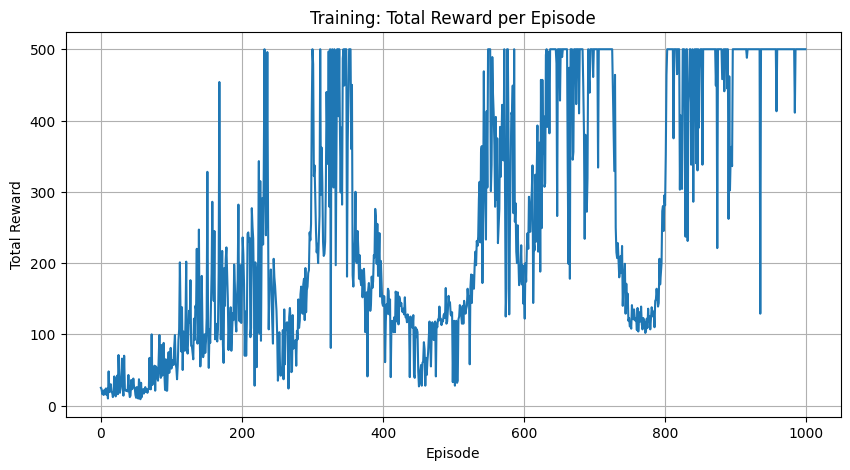

Evaluation Episode 0: Reward = 500.00
Evaluation Episode 1: Reward = 500.00
Evaluation Episode 2: Reward = 500.00
Evaluation Episode 3: Reward = 500.00
Evaluation Episode 4: Reward = 500.00
Evaluation Episode 5: Reward = 500.00
Evaluation Episode 6: Reward = 500.00
Evaluation Episode 7: Reward = 500.00
Evaluation Episode 8: Reward = 500.00
Evaluation Episode 9: Reward = 500.00


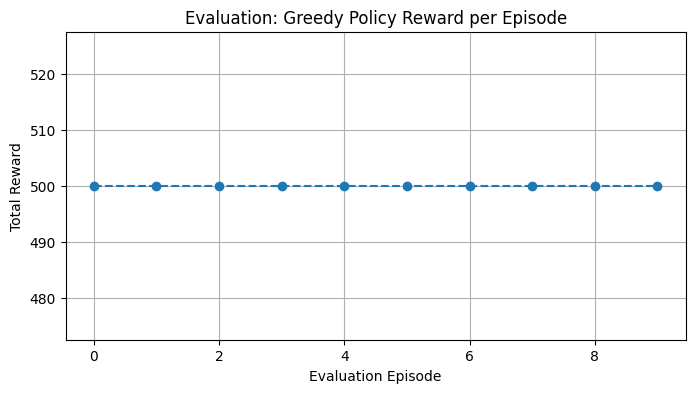

Global model weights saved.


In [32]:
env_name = "CartPole-v1" 
env = gym.make(env_name)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
env.close()
hidden_dim = 256
maxEp = 1000         
num_workers = 2            
learning_rate = 5e-4
global_model = ActorCritic(input_dim, hidden_dim, output_dim)     #creating global model
global_model.share_memory()  
global_model.to(device)
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
glob_epref = [0]  
glob_epRwd = [] 

start_time = time.time()
print("Now we are stating the training with multiple threads")
train_threads(global_model, optimizer, maxEp, num_workers, env_name, glob_epref, glob_epRwd)
elapsed = time.time() - start_time
print(f"Training is complete in {elapsed:.2f} seconds.")

plt.figure(figsize=(10, 5))
plt.plot(glob_epRwd)
plt.title("Training: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

eval_rewards = evaluate_model(global_model, env_name, num_episodes=10)
plt.figure(figsize=(8, 4))
plt.plot(eval_rewards, marker='o', linestyle='--')
plt.title("Evaluation: Greedy Policy Reward per Episode")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

torch.save(global_model.state_dict(), "a3_part_2_a2c_cartpole.pth")
print("Global model weights saved.")

# Lunar Lander v3

Now we are stating the training with multiple threads
The thread with thread ID 0 is now stated to train.
The thread with thread ID 1 is now stated to train.
The thread with ID 1 finished the episode 1 which took it 77 steps with reward -75.79
The thread with ID 0 finished the episode 0 which took it 120 steps with reward -289.35
The thread with thread ID 1 and episode 1 has gradients after clipping is: 10.000
The thread with ID 1 finished the episode 2 which took it 90 steps with reward -396.29
The thread with thread ID 0 and episode 0 has gradients after clipping is: 10.000
The thread with ID 0 finished the episode 3 which took it 82 steps with reward -147.08
The thread with thread ID 1 and episode 2 has gradients after clipping is: 10.000
The thread with thread ID 0 and episode 3 has gradients after clipping is: 10.000
The thread with ID 1 finished the episode 4 which took it 114 steps with reward -214.83
The thread with ID 0 finished the episode 5 which took it 105 steps with rewar

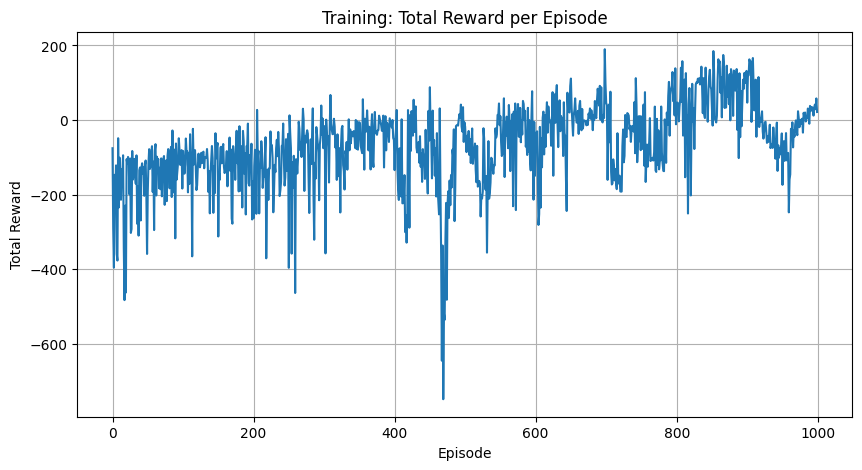

Evaluation Episode 0: Reward = 24.25
Evaluation Episode 1: Reward = 0.40
Evaluation Episode 2: Reward = 70.41
Evaluation Episode 3: Reward = 230.54
Evaluation Episode 4: Reward = 63.22
Evaluation Episode 5: Reward = 9.68
Evaluation Episode 6: Reward = 239.00
Evaluation Episode 7: Reward = 4.12
Evaluation Episode 8: Reward = 54.09
Evaluation Episode 9: Reward = 45.63


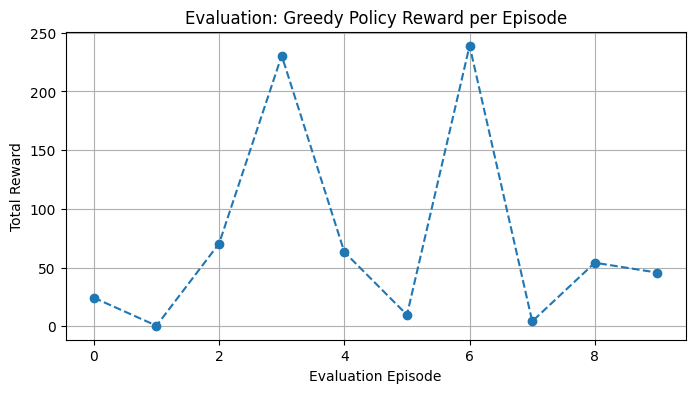

Global model weights saved.


In [34]:
#Lunar Lander v 3

class ActorCriticLL(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu = nn.ReLU()
        self.sharedLayers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim)
            )
            
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
            )
    
    def forward(self, x):
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.sharedLayers(x)
        policy_logits = self.policy(x)
        value = self.value(x)
        return policy_logits, value

def worker_thread(IDthread, global_model, optimizer, epLock, optimLock, glob_epref, glob_epRwd, maxEp, env_name):
    env = gym.make(env_name)                                                      #The idea here is that each thread creates its own local environment and syncs with the global model from time to time
    env.reset(seed=seed + IDthread)          #To differenciate we are setting unique seeds with thread ID, to easily identify
    local_model = ActorCriticLL(input_dim=env.observation_space.shape[0], hidden_dim=256, output_dim=env.action_space.n)
    local_model.load_state_dict(global_model.state_dict())          #We are creating a copy of global model
    local_model.to(device)
    gamma = 0.99
    entropy_coeff = 0.01                                       # we know that entropy pushes the model to explore
    print(f"The thread with thread ID {IDthread} is now stated to train.")
    
    while True:
        with epLock:                       #hre we are incrementing the global episode 
            if glob_epref[0] >= maxEp:
                break
            epID = glob_epref[0]
            glob_epref[0] += 1

        state, _ = env.reset()  
        log_probs = []                 #now we start to run one episode
        entropies = []
        values = []
        rewards = []
        done = False
        ep_rwd = 0
        stepCnt = 0
        while not done:
            stepCnt += 1
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)     # we ae converting state to float tensor and adding extra dimension
            logits, value = local_model(state_tensor) #getting estimation from actor and critic heads. 
            probs = torch.softmax(logits, dim=-1)         #here we are converting logits into probabilities using softmax
            action = torch.multinomial(probs, num_samples=1).item() #We are sampeling action from given probs
            log_prob = torch.log(probs.squeeze(0)[action])
            entropy = -(probs * torch.log(probs + 1e-8)).sum()   #Calcuating the entropy for exploration
            next_state, reward, terminated, truncated, _ = env.step(action)  #Taking that action on environment and getting reward and next state from the step function
            done = terminated or truncated 
            log_probs.append(log_prob)
            entropies.append(entropy)
            values.append(value.squeeze(0))
            rewards.append(reward)
            ep_rwd += reward
            state = next_state

        print(f"The thread with ID {IDthread} finished the episode {epID} which took it {stepCnt} steps with reward {ep_rwd:.2f}")
        
        rtns = compute_returns(rewards, gamma)       #Now we compute the returns and advantage
        rtns = torch.FloatTensor(rtns).to(device)
        values = torch.stack(values)
        advantages = rtns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)    #Normalizing the advantage in this line
        total_entropy = torch.stack(entropies).sum()
        actor_loss = -(torch.stack(log_probs) * advantages.detach()).sum() - entropy_coeff * total_entropy
        critic_loss = advantages.pow(2).sum()
        total_loss = actor_loss + 0.5 * critic_loss
        optimizer.zero_grad()
        total_loss.backward()  #Backpropogating the loss to make adjustments in weights

        torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=10)  #Clipping the gradient so that no dractic changes takes place
        normClipped = sum(p.grad.data.norm(2).item()**2 for p in local_model.parameters() if p.grad is not None)**0.5
        print(f"The thread with thread ID {IDthread} and episode {epID} has gradients after clipping is: {normClipped:.3f}")
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            if local_param.grad is not None:
                global_param.grad = local_param.grad
        with optimLock:          #we use this lock to avoid race condition
            optimizer.step()        
        local_model.load_state_dict(global_model.state_dict())     #making the local model in sync with global model
        local_model.to(device)
        glob_epRwd.append(ep_rwd)
    
    env.close()
    print(f"The thread {IDthread} is succesufully finished.")

env_name = "LunarLander-v3" 
env = gym.make(env_name)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
env.close()
hidden_dim = 256
maxEp = 1000         
num_workers = 2            
learning_rate = 5e-4
global_model = ActorCriticLL(input_dim, hidden_dim, output_dim)     #creating global model
global_model.share_memory()  
global_model.to(device)
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
glob_epref = [0]  
glob_epRwd = [] 

start_time = time.time()
print("Now we are stating the training with multiple threads")
train_threads(global_model, optimizer, maxEp, num_workers, env_name, glob_epref, glob_epRwd)
elapsed = time.time() - start_time
print(f"Training is complete in {elapsed:.2f} seconds.")

plt.figure(figsize=(10, 5))
plt.plot(glob_epRwd)
plt.title("Training: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

eval_rewards = evaluate_model(global_model, env_name, num_episodes=10)
plt.figure(figsize=(8, 4))
plt.plot(eval_rewards, marker='o', linestyle='--')
plt.title("Evaluation: Greedy Policy Reward per Episode")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

torch.save(global_model.state_dict(), "a3_part_2_a2c_lunarlanderv3.pth")
print("Global model weights saved.")

# CarRacing 

Now we are stating the training with multiple threads
The thread with thread ID 1 is now stated to train.
The thread with thread ID 0 is now stated to train.
The thread with ID 1 finished the episode 0 which took it 1000 steps with reward -50.38
The thread with ID 0 finished the episode 1 which took it 1000 steps with reward -60.66
The thread with thread ID 1 and episode 0 has gradients after clipping is: 10.000The thread with thread ID 0 and episode 1 has gradients after clipping is: 10.000

The thread with ID 1 finished the episode 3 which took it 1000 steps with reward -58.65
The thread with ID 0 finished the episode 2 which took it 1000 steps with reward -56.23
The thread with thread ID 1 and episode 3 has gradients after clipping is: 10.000
The thread with thread ID 0 and episode 2 has gradients after clipping is: 10.000
The thread with ID 1 finished the episode 4 which took it 1000 steps with reward -67.03
The thread with ID 0 finished the episode 5 which took it 1000 steps with 

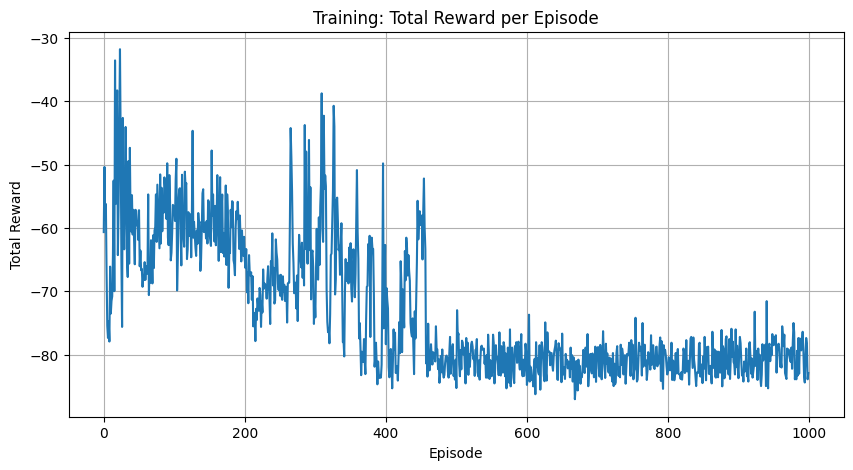

Evaluation Episode 0: Reward = -93.69
Evaluation Episode 1: Reward = -92.86
Evaluation Episode 2: Reward = -93.22
Evaluation Episode 3: Reward = -92.67
Evaluation Episode 4: Reward = -93.88
Evaluation Episode 5: Reward = -93.29
Evaluation Episode 6: Reward = -93.01
Evaluation Episode 7: Reward = -92.88
Evaluation Episode 8: Reward = -92.88
Evaluation Episode 9: Reward = -93.36


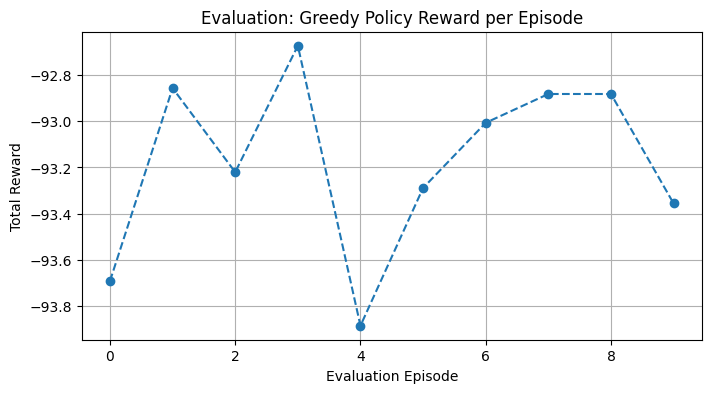

Global model weights saved.


In [ ]:
#Car Racing -v3 

#Modifying ActorCritic for Continuous Action Space of CarRacing

class ActorCriticContinuousAS(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCriticContinuousAS, self).__init__()
        self.cnn = nn.Sequential(
             nn.Conv2d(3,32,kernel_size=8,stride=2),
             nn.ReLU(),
             nn.Conv2d(32,64,kernel_size=4,stride=2),
             nn.ReLU(),
             nn.Conv2d(64,64,kernel_size=2,stride=2),
             nn.ReLU(),
        )
        self.flattenLayer = nn.Flatten()
        self.fc = nn.Linear(64*10*10,256)
        self.muHead = nn.Linear(hidden_dim, output_dim)
        self.logStdHead = nn.Parameter(torch.zeros(output_dim))

        #Critic
        self.valueHead = nn.Linear(hidden_dim, 1)
    
  def forward(self, x):
        x = x/255
        x = self.cnn(x)
        x = self.flattenLayer(x)
        x = torch.relu(self.fc(x))
        mean = torch.tanh(self.muHead(x))
        std = torch.exp(self.logStdHead).expand_as(mean)
        value = self.valueHead(x)
        return mean, std, value #this is used to create a normal distribution for the action

def compute_returns(rewards, gamma=0.99):
    R = 0
    rtns = []
    for r in reversed(rewards):
        R = r + gamma * R
        rtns.insert(0, R)   #here we are prepending with 0 so tha the returns can align with original order later
    return rtns

def worker_thread(IDthread, global_model, optimizer, epLock, optimLock, glob_epref, glob_epRwd, maxEp, env_name):
    env = gym.make(env_name)                                                      #The idea here is that each thread creates its own local environment and syncs with the global model from time to time
    env.reset(seed=seed + IDthread)          #To differenciate we are setting unique seeds with thread ID, to easily identify
    local_model = ActorCriticContinuousAS(
        input_dim=env.observation_space.shape[0],
        hidden_dim=256,
        output_dim=env.action_space.shape[0]
        )
    local_model.load_state_dict(global_model.state_dict())          #We are creating a copy of global model
    local_model.to(device)
    gamma = 0.99
    entropy_coeff = 0.01                                       # we know that entropy pushes the model to explore
    print(f"The thread with thread ID {IDthread} is now stated to train.")
    
    while True:
        with epLock:                       #here we are incrementing the global episode 
            if glob_epref[0] >= maxEp:
                break
            epID = glob_epref[0]
            glob_epref[0] += 1

        state, _ = env.reset()  
        log_probs = []                 #now we start to run one episode
        entropies = []
        values = []
        rewards = []
        done = False
        ep_rwd = 0
        stepCnt = 0
        while not done:
            stepCnt += 1
            state_tensor = torch.FloatTensor(state).permute(2, 0, 1).unsqueeze(0).to(device)     # we ae converting state to float tensor and adding extra dimension
            mean, std, value = local_model(state_tensor) 
            distribution = torch.distributions.Normal(mean, std) 
            action = distribution.sample()
            actionClipped = torch.clamp(action,-1.0,1.0)
            log_prob = distribution.log_prob(actionClipped).sum(dim=-1)
            entropy = distribution.entropy().sum(dim=-1)   #Calcuating the entropy for exploration
            next_state, reward, terminated, truncated, _ = env.step(actionClipped.cpu().numpy()[0])  #Taking that action on environment and getting reward and next state from the step function
            done = terminated or truncated 
            log_probs.append(log_prob)
            entropies.append(entropy)
            values.append(value.squeeze(0))
            rewards.append(reward)
            ep_rwd += reward
            state = next_state

        print(f"The thread with ID {IDthread} finished the episode {epID} which took it {stepCnt} steps with reward {ep_rwd:.2f}")
        
        rtns = compute_returns(rewards, gamma)       #Now we compute the returns and advantage
        rtns = torch.FloatTensor(rtns).to(device)
        values = torch.stack(values)
        advantages = rtns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)    #Normalizing the advantage in this line
        total_entropy = torch.stack(entropies).sum()
        actor_loss = -(torch.stack(log_probs) * advantages.detach()).sum() - entropy_coeff * total_entropy
        critic_loss = advantages.pow(2).sum()
        total_loss = actor_loss + 0.5 * critic_loss
        optimizer.zero_grad()
        total_loss.backward()  #Backpropogating the loss to make adjustments in weights

        torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=10)  #Clipping the gradient so that no dractic changes takes place
        normClipped = sum(p.grad.data.norm(2).item()**2 for p in local_model.parameters() if p.grad is not None)**0.5
        print(f"The thread with thread ID {IDthread} and episode {epID} has gradients after clipping is: {normClipped:.3f}")
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            if local_param.grad is not None:
                global_param.grad = local_param.grad
        with optimLock:          #we use this lock to avoid race condition
            optimizer.step()        
        local_model.load_state_dict(global_model.state_dict())     #making the local model in sync with global model
        local_model.to(device)
        glob_epRwd.append(ep_rwd)
    
    #env.close()
    print(f"The thread {IDthread} is succesufully finished.")


def evaluate_model(global_model, env_name, num_episodes=10):
    global_model.to(device)
    env = gym.make(env_name)
    eval_rewards = []
    for ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            state = np.transpose(state, (2,0,1))
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                mean,_,_ = global_model(state_tensor)
                action = mean
                actionClipped = torch.clamp(action,-1.0,1.0)
            state, reward, terminated, truncated, _ = env.step(actionClipped.cpu().numpy()[0])
            done = terminated or truncated
            total_reward += reward
        eval_rewards.append(total_reward)
        print(f"Evaluation Episode {ep}: Reward = {total_reward:.2f}")
    env.close()
    return eval_rewards

env_name="CarRacing-v3"
env = gym.make(env_name)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.shape[0]
env.close()
hidden_dim = 256
maxEp = 1000         
num_workers = 2            
learning_rate = 5e-4
global_model = ActorCriticContinuousAS(input_dim, hidden_dim,output_dim)     #creating global model
global_model.share_memory()  
global_model.to(device)
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
glob_epref = [0]  
glob_epRwd = [] 

start_time = time.time()
print("Now we are stating the training with multiple threads")
train_threads(global_model, optimizer, maxEp, num_workers, env_name, glob_epref, glob_epRwd)
elapsed = time.time() - start_time
print(f"Training is complete in {elapsed:.2f} seconds.")

plt.figure(figsize=(10, 5))
plt.plot(glob_epRwd)
plt.title("Training: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

eval_rewards = evaluate_model(global_model, env_name, num_episodes=10)
plt.figure(figsize=(8, 4))
plt.plot(eval_rewards, marker='o', linestyle='--')
plt.title("Evaluation: Greedy Policy Reward per Episode")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

torch.save(global_model.state_dict(), "a3_part_2_a2c_car_racing.pth")
print("Global model weights saved.")